# Ariel/Sat. Landslide Data Loading
The following notebook is a guide to load image data sets for model training and validation. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile

2024-11-30 16:34:12.588671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 16:34:12.936010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 16:34:13.077881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:34:13.889650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Relevant Links:
0. Trial Link just to test linkages: Please try.<br>
https://www.dropbox.com/scl/fi/ryo0gocx5ibsttv0635jg/ls_model_data_two_v2.zip?rlkey=i6fg2du9osvc0h6hpcoul1xa1&dl=0  <br>

1. Link 1 contains Training landslide images from Longxi River UAV and non-landslide images from DeepGlobe Land Cover Classification Dataset. 
Working on this - resizing to get the zip file much lower, to 1.5G.
https://www.dropbox.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0

2. ls_model_data_four: includes training images from Longxihe_UAV, Lombok, Moxitown (UAV-.2m) and Hokkaido.
https://www.dropbox.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0

3. Old Test Images (Google) <br>
https://dl.dropboxusercontent.com/scl/fi/wbi8iuftwvwnflvjr15pv/test_googleimages_land.zip?rlkey=h2stfvt9ocltsog29l26wo1ls&dl=0?raw=1

4. ls_model_data_five: includes 3304 Landslide and 3940 Non Landslide images. <br>
https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1
Images from:
- https://huggingface.co/datasets/satellite-image-deep-learning/SODA-A/tree/main
- https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
- And CAS: Longxihe_UAV, Lombok, Moxitown (UAV-.2m) and Hokkaido.

5. New Test Set (Google) <br>
https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1

6. New Test Set for Train/Validation/Test of 2nd Model <br>
https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1


Notes per DropBox Requirements:
- Add ?raw=1 to the end of the dropbox link in the full URL link as seen below. 
- replace dropbox.com in link with "dl.dropboxusercontent.com" as seen below. 

In [2]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"

In [3]:
data_dir = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6974


In [5]:
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [6]:
# Drill into each subdirectory and list counts per folder
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3034 .jpg images

Contents of folder 'non_landslide':
non_landslide: 3940 .jpg images


## Helper

In [7]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(500,500)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

### Review an image:

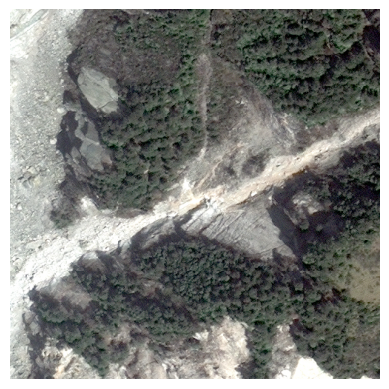

In [21]:
landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[50]))
resize_show(landslide_one[150])

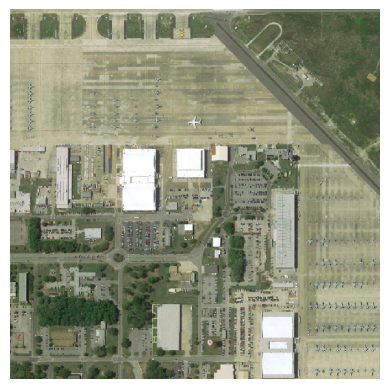

In [22]:
# landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[0]))

non_landslide_img = list(data_dir.glob('non_landslide/*'))
# PIL.Image.open(str(non_landslide_img[1]))
resize_show(non_landslide_img[120])

## Separate Test Set

In [2]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

test_dataset_url = 'https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1'

In [3]:
data_dir_test = tf.keras.utils.get_file('test_google_images_landslides_four.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

97215859/97215859 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [5]:
# Drill into each subdirectory and list files
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 57 .jpg images
  Subfolder: non-landslides
non-landslides: 73 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg


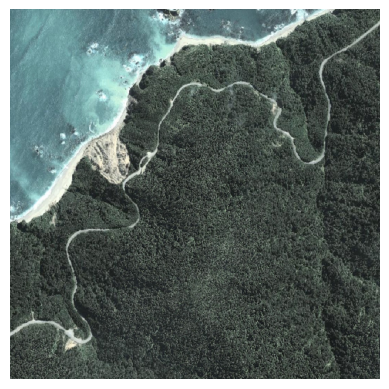

In [14]:
## Review an image
test_one = list(data_dir_test.glob('Google_Earth_Images/landslides/*'))
# PIL.Image.open(str(test_one[2]))
resize_show(test_one[25])

## **Create the model dataset**

In [20]:
## Add new Import package to chunk above.  
## from collections import Counter
## from sklearn.utils.class_weight import compute_class_weight

In [52]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [53]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 5580 files for training.


In [54]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 1394 files for validation.


In [59]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset.unbatch())
valid_count = sum(1 for _ in valid_dataset.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset, train_class_counts)
count_classes(valid_dataset, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

Training set size: 5580
Validation set size: 1394

Class distribution in Training set:
  Class 0: 2428 samples
  Class 1: 3152 samples

Class distribution in Validation set:
  Class 0: 606 samples
  Class 1: 788 samples


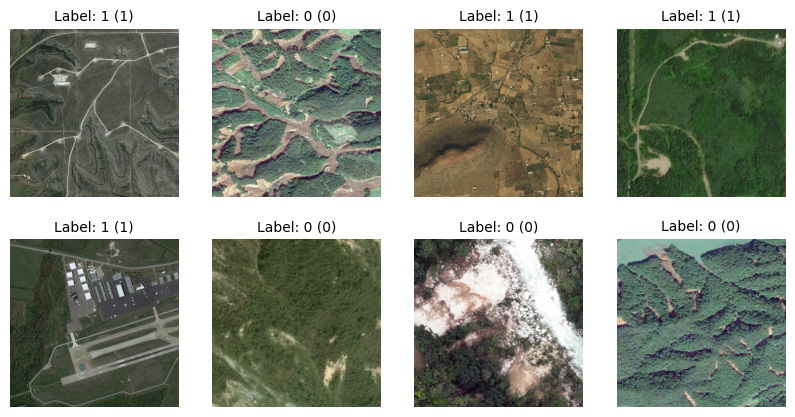

In [64]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #0a0849">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [57]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.1490939044481054, 1: 0.8851522842639594}
